In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.signal import argrelextrema
%matplotlib inline

In [3]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [4]:
Hs = mean + 4 * std

In [18]:
(test  > Hs).sum()

833

In [5]:
lstm_predicts = []
for i in range(19):
    lstm_predicts.append(np.load("predicts/lstm_predict_" + str(i) + ".npy"))

In [6]:
def Calc_TP(predict, target, k, n, m):

    assert len(predict) == len(target)

    TP = 0
    i = n
    TP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - k + 1: i + n] > Hs).any() and (test[i-m: i - k + 1] < Hs).all():
                #print(i)
                TP_lst.append(i)
                i += n
                TP += 1
        i += 1
    return TP, TP_lst

In [7]:
wave_net_predicts = np.load("predicts/wavenet_predict_all_steps.npy")

In [8]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans     

In [9]:
test_right_part = (len(test)- 20)%64
TPs_lstm = []
TPs_wave = []
for i in range(19):
    TP_wave, _ = Calc_TP(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], test[i+1:], i+1, 50, 5 + i)
    TPs_wave.append(TP_wave)
    if i:
        TP_lstm, _ = Calc_TP(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        TPs_lstm.append(TP_lstm)
    else:
        TP_lstm, _ = Calc_TP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        TPs_lstm.append(TP_lstm)
    

In [15]:
TPs_wave

[635,
 481,
 370,
 385,
 377,
 367,
 353,
 367,
 344,
 348,
 352,
 348,
 349,
 357,
 354,
 367,
 359,
 344,
 328]

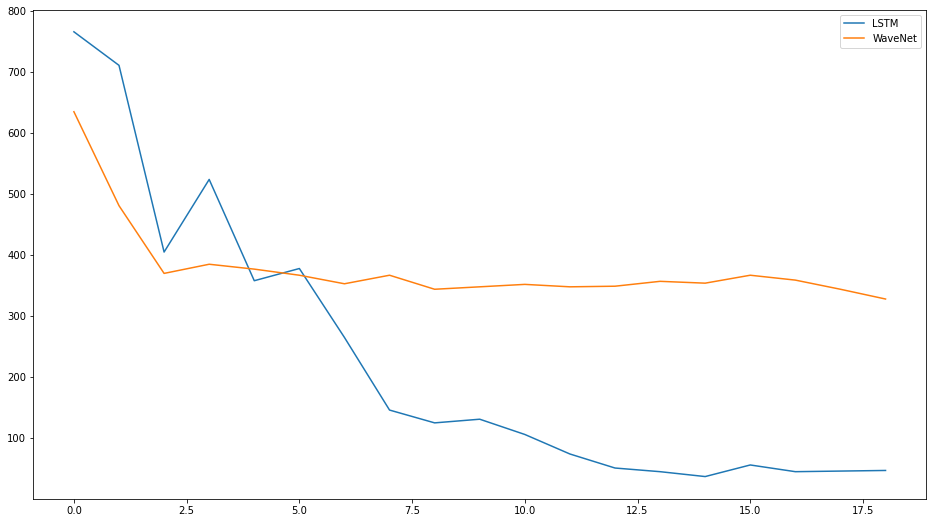

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(TPs_lstm, label="LSTM")
plt.plot(TPs_wave, label="WaveNet")
plt.legend()

In [10]:
def Calc_FN(predict, target, k, n, m):

    assert len(predict) == len(target)

    FN = 0
    i = n
    FN_lst = []
    while i < len(predict):
        if target[i] > Hs:
            if (predict[i - n: i + k] < Hs).all():
                #print(i)
                #return FN
                FN_lst.append(i)
                i += n
                FN += 1
        i += 1
    return FN, FN_lst

In [11]:
test_right_part = (len(test)- 20)%64
FNs_lstm = []
FNs_wave = []
for i in range(19):
    FN_wave, _ = Calc_FN(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], test[i+1:], i+1, 50, 5 + i)
    FNs_wave.append(FN_wave)
    if i:
        FN_lstm, _ = Calc_FN(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        FNs_lstm.append(FN_lstm)
    else:
        FN_lstm, _ = Calc_FN(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        FNs_lstm.append(FN_lstm)
    

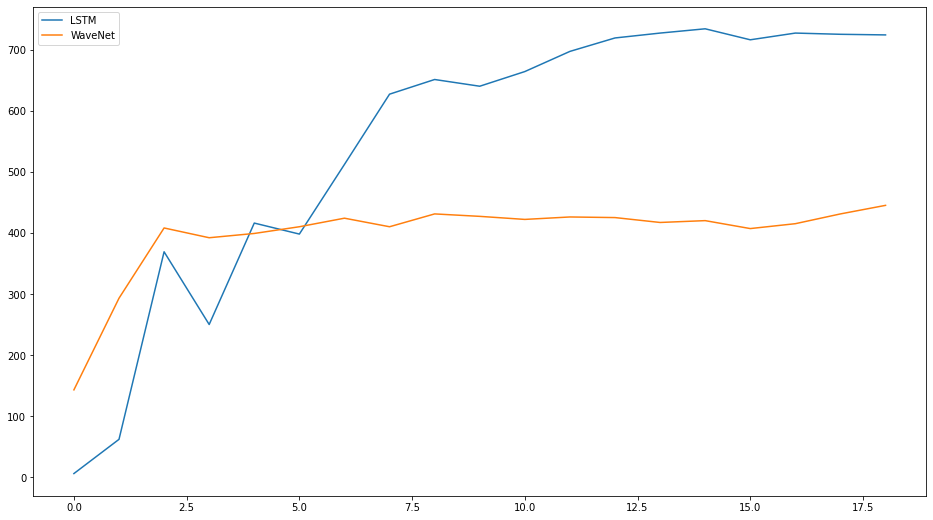

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(FNs_lstm, label="LSTM")
plt.plot(FNs_wave, label="WaveNet")
plt.legend()

In [12]:
def Calc_FP(predict, target, k, n, m):

    assert len(predict) == len(target)

    FP = 0
    i = n
    FP_lst = []
    while i < len(predict):
        if predict[i] > Hs:
            if (target[i - n: i + n] < Hs).all():
                #print(i)
                #return FN
                FP_lst.append(i)
                i += n
                FP += 1
        i += 1
    return FP, FP_lst

In [13]:
test_right_part = (len(test)- 20)%64
FPs_lstm = []
FPs_wave = []
for i in range(19):
    FP_wave, _ = Calc_FP(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], test[i+1:], i+1, 50, 5 + i)
    FPs_wave.append(FP_wave)
    if i:
        FP_lstm, _ = Calc_FP(lstm_predicts[i][:-i], test[20+i:-test_right_part], i+1, 50, 5 + i)
        FPs_lstm.append(FP_lstm)
    else:
        FP_lstm, _ = Calc_FP(lstm_predicts[0], test[20:-test_right_part], 1, 50, 5)
        FPs_lstm.append(FP_lstm)
    

In [14]:
pres_wave = []
pres_lstm = []
for i in range(len(TPs_wave)):
    if (TPs_wave[i]):
        pres_wave.append(TPs_wave[i] / (TPs_wave[i] + FPs_wave[i]))
        pres_lstm.append(TPs_lstm[i] / (TPs_lstm[i] + FPs_lstm[i]))
        
    else:
        pres_wave.append(0)
        pres_lstm.append(0)        

In [15]:
rec_wave = []
rec_lstm = []
for i in range(len(TPs_wave)):
    if (TPs_wave[i]):
        rec_wave.append(TPs_wave[i] / (TPs_wave[i] + FNs_wave[i]))
        rec_lstm.append(TPs_lstm[i] / (TPs_lstm[i] + FNs_lstm[i]))
        
    else:
        rec_wave.append(0)
        rec_lstm.append(0)     

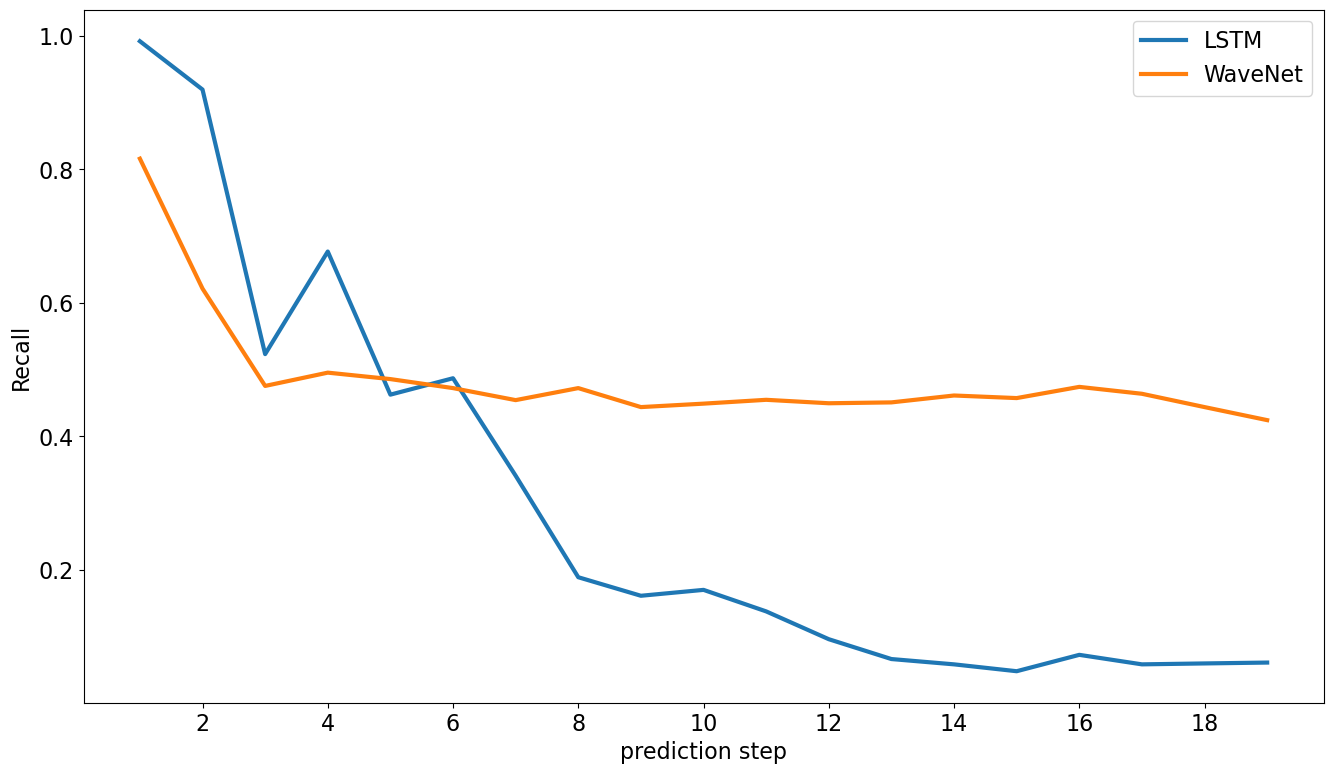

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(list(range(1, 20)), rec_lstm, label="LSTM", linewidth = 3)
ax.plot(list(range(1, 20)), rec_wave, label="WaveNet", linewidth = 3)



ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("Recall",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

ax.legend(fontsize = 16)


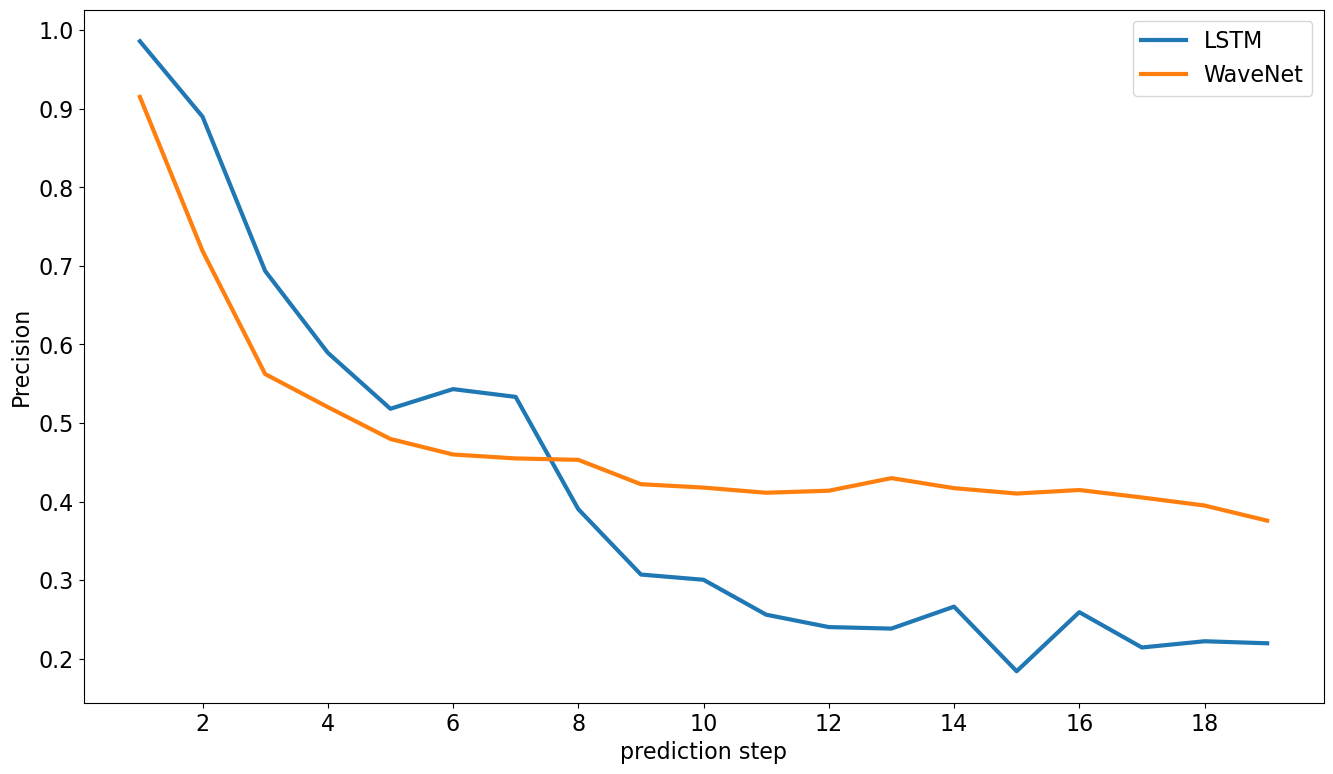

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(list(range(1, 20)), pres_lstm, label="LSTM", linewidth = 3)
ax.plot(list(range(1, 20)), pres_wave, label="WaveNet", linewidth = 3)



ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel("Precision",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

ax.legend(fontsize = 16)

In [14]:
TPs_wave[0] / (TPs_wave[0] + FNs_wave[0])

0.8161953727506427

In [17]:
TPs_wave[0] / (TPs_wave[0] + FPs_wave[0])

0.9149855907780979

In [16]:
(TPs_wave[0] + FNs_wave[0])

778

In [15]:
FPs_wave[0]

59

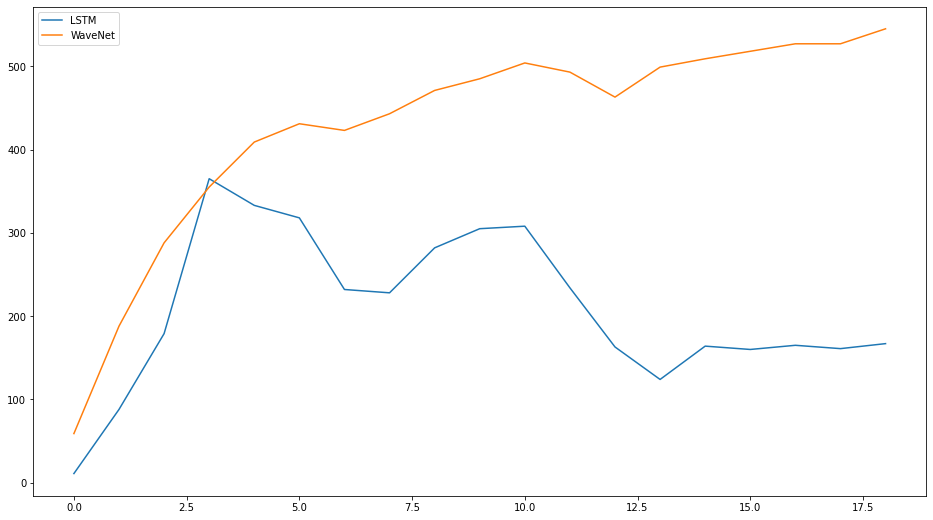

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(FPs_lstm, label="LSTM")
plt.plot(FPs_wave, label="WaveNet")
plt.legend()

In [ ]:
# def Calc_dist(predict, target, k, n, m):

#     assert len(predict) == len(target)

#     TP = 0
#     i = n
#     TP_lst = []
#     while i < len(predict):
#         if predict[i] > Hs:
#             if (target[i - k + 1: i + n] > Hs).any() and (test[i-m: i - k + 1] < Hs).all():
#                 #print(i)
#                 TP_lst.append(i)
#                 i += n
#                 TP += 1
#         i += 1
#     return TP, TP_lst

In [17]:
def OnlyPeaks(time_series):
    spikes_ind = argrelextrema(time_series, np.greater) 
    spikes = time_series[spikes_ind]
    return spikes